In [1]:
import gym # i used 0.10.5
import numpy as np # i used 1.14.3
import datetime
import keras # i used 2.1.16 with tensorflow 1.8.0/
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
env = gym.make('Pong-v0')
observation = env.reset()
observation.shape

(210, 160, 3)

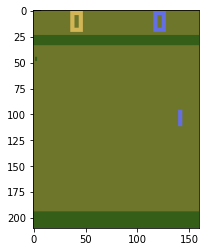

In [4]:
plt.imshow(observation)

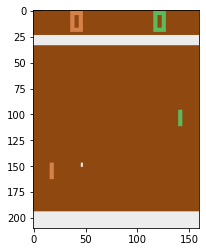

In [5]:
# i take some steps to see middle game scene
# in pong game,
# 0 is numeric action to stay at same place 
# 2 is numeric action to move paddle up in game
# 3 is numeric action to move paddle down in game
for i in range(30):
    observation, reward, done, info = env.step(0)# 0 means stay the same place(or do nothing)
    
plt.imshow(observation)

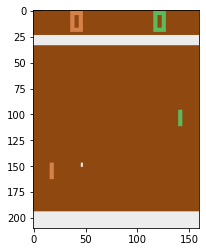

In [6]:
new_observation, reward, done, info = env.step(2)
plt.imshow(observation)

In [7]:
def preprocess_frames(new_frame,last_frame):
    # inputs are 2 numpy 2d arrays
    n_frame = new_frame.astype(np.int32)
    n_frame[(n_frame==144)|(n_frame==109)]=0 # remove backgound colors
    l_frame = last_frame.astype(np.int32)
    l_frame[(l_frame==144)|(l_frame==109)]=0 # remove backgound colors
    diff = n_frame - l_frame
    # crop top and bot 
    diff = diff[35:195]
    # down sample 
    diff=diff[::2,::2]
    # convert to grayscale
    diff = diff[:,:,0] * 299. / 1000 + diff[:,:,1] * 587. / 1000 + diff[:,:,2] * 114. / 1000
    # rescale numbers between 0 and 1
    max_val =diff.max() if diff.max()> abs(diff.min()) else abs(diff.min())
    if max_val != 0:
        diff=diff/max_val
    return diff

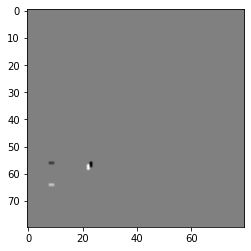

In [8]:
plt.imshow(preprocess_frames(new_observation,observation),plt.cm.gray)

In [9]:
preprocess_frames(new_observation,observation)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
preprocess_frames(new_observation,observation).shape

(80, 80)

##  Modeling the Network

In [11]:
# simple 2 layer model 
# with 200 hidden units in first layer
# and 1 sigmoid output
inputs = keras.layers.Input(shape=(80,80))
flattened_layer = keras.layers.Flatten()(inputs)
full_connect_1 = keras.layers.Dense(units=200,activation='relu',use_bias=False,)(flattened_layer)
sigmoid_output = keras.layers.Dense(1,activation='sigmoid',use_bias=False)(full_connect_1)
policy_network_model = keras.models.Model(inputs=inputs,outputs=sigmoid_output)
policy_network_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               1280000   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


In [12]:
# another model
# with convolutional layers 
# it has about 31000 parameters

# inputs = keras.layers.Input(shape=(80,80))
# channeled_input = keras.layers.Reshape((80,80,1))(inputs) # Conv2D requries (batch, height, width, channels)  so we need to create a dummy channel 
# conv_1 = keras.layers.Conv2D(filters=10,kernel_size=20,padding='valid',activation='relu',strides=(4,4),use_bias=False)(channeled_input)
# conv_2 = keras.layers.Conv2D(filters=20,kernel_size=10,padding='valid',activation='relu',strides=(2,2),use_bias=False)(conv_1)
# conv_3 = keras.layers.Conv2D(filters=40,kernel_size=3,padding='valid',activation='relu',use_bias=False)(conv_2)
# flattened_layer = keras.layers.Flatten()(conv_3)
# sigmoid_output = keras.layers.Dense(1,activation='sigmoid',use_bias=False)(flattened_layer)
# policy_network_model = keras.models.Model(inputs=inputs,outputs=sigmoid_output)
# policy_network_model.summary()

# Defining Loss

In [13]:
episode_reward = keras.layers.Input(shape=(1,),name='episode_reward')

In [14]:
def m_loss(episode_reward):
    def loss(y_true,y_pred):
        # feed in y_true as actual action taken 
        # if actual action was up, we feed 1 as y_true and otherwise 0
        # y_pred is the network output(probablity of taking up action)
        # note that we dont feed y_pred to network. keras computes it
        
        # first we clip y_pred between some values because log(0) and log(1) are undefined
        tmp_pred = keras.layers.Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(y_pred)
        # we calculate log of probablity. y_pred is the probablity of taking up action
        # note that y_true is 1 when we actually chose up, and 0 when we chose down
        # this is probably similar to cross enthropy formula in keras, but here we write it manually to multiply it by the reward value
        tmp_loss = keras.layers.Lambda(lambda x:-y_true*keras.backend.log(x)-(1-y_true)*(keras.backend.log(1-x)))(tmp_pred)
        # multiply log of policy by reward
        policy_loss=keras.layers.Multiply()([tmp_loss,episode_reward])
        return policy_loss
    return loss

In [15]:
episode_reward = keras.layers.Input(shape=(1,),name='episode_reward')
policy_network_train = keras.models.Model(inputs=[inputs,episode_reward],outputs=sigmoid_output)

my_optimizer = keras.optimizers.RMSprop(lr=0.0001)
policy_network_train.compile(optimizer=my_optimizer,loss=m_loss(episode_reward),)

# Reward Engineering

In [16]:
def generate_episode(policy_network):
    states_list = [] # shape = (x,80,80)
    up_or_down_action_list=[] # 1 if we chose up. 0 if down
    rewards_list=[]
    network_output_list=[]
    env=gym.make("Pong-v0")
    observation = env.reset()
    new_observation = observation
    done = False
    policy_output_list = []
    
    while done == False:
    
        processed_network_input = preprocess_frames(new_frame=new_observation,last_frame=observation)
        states_list.append(processed_network_input)
        reshaped_input = np.expand_dims(processed_network_input,axis=0) # x shape is (80,80) so we need similar reshape(x,(1,80,80))

        up_probability = policy_network.predict(reshaped_input,batch_size=1)[0][0]
        network_output_list.append(up_probability)
        policy_output_list.append(up_probability)
        actual_action = np.random.choice(a=[2,3],size=1,p=[up_probability,1-up_probability]) # 2 is up. 3 is down 
        if actual_action==2:
            up_or_down_action_list.append(1)
        else:
            up_or_down_action_list.append(0)
        
        observation= new_observation
        new_observation, reward, done, info = env.step(actual_action)
        
        rewards_list.append(reward)
        
        if done:
            break
            
    env.close()
    return states_list,up_or_down_action_list,rewards_list,network_output_list

In [17]:
states_list,up_or_down_action_list,rewards_list,network_output_list = generate_episode(policy_network_model)

In [18]:
print("length of states= "+str(len(states_list)))# this is the number of frames
print("shape of each state="+str(states_list[0].shape))
print("length of rewards= "+str(len(rewards_list)))

length of states= 1102
shape of each state=(80, 80)
length of rewards= 1102


In [19]:
# lets see sample of policy output
print(network_output_list[30:50])

[0.48949, 0.505313, 0.50034374, 0.5112063, 0.47803304, 0.50664026, 0.5222534, 0.5079792, 0.50031585, 0.4839182, 0.50091386, 0.5048503, 0.4986176, 0.4878279, 0.5024162, 0.47971866, 0.48274967, 0.5118669, 0.49721506, 0.5082506]


In [20]:
#lets see a sample what we actually did: 1 means we went up, 0 means down
up_or_down_action_list[30:50]

[1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1]

In [21]:
# lets see sample of rewards
print(rewards_list[50:100])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [22]:
# lets see how many times we won through whole game:
print("count win="+str(len(list(filter(lambda r: r>0,rewards_list)))))
print("count lose="+str(len(list(filter(lambda r: r<0,rewards_list)))))
print("count zero rewards="+str(len(list(filter(lambda r: r==0,rewards_list)))))

count win=0
count lose=21
count zero rewards=1081


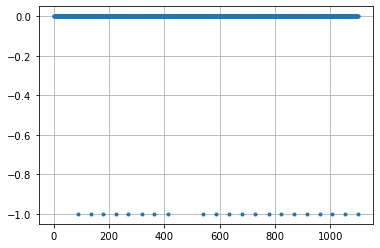

In [23]:
plt.plot(rewards_list,'.')
ax=plt.gca()
ax.grid(True)

In [24]:
def process_rewards(r_list):
    reward_decay=0.99
    tmp_r=0
    rew=np.zeros_like(r_list,dtype=np.float32)
    for i in range(len(r_list)-1,-1,-1):
        if r_list[i]==0:
            tmp_r=tmp_r*reward_decay
            rew[i]=tmp_r
        else: 
            tmp_r = r_list[i]
            rew[i]=tmp_r
    return rew

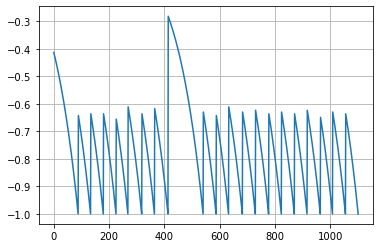

In [25]:
# lets see what this gives us:
plt.plot(process_rewards(rewards_list),'-')
ax=plt.gca()
ax.grid(True)

In [26]:
def process_rewards(r_list):
    reward_decay=0.99
    tmp_r=0
    rew=np.zeros_like(r_list,dtype=np.float32)
    for i in range(len(r_list)-1,-1,-1):
        if r_list[i]==0:
            tmp_r=tmp_r*reward_decay
            rew[i]=tmp_r
        else: 
            tmp_r = r_list[i]
            rew[i]=tmp_r
    rew -= np.mean(rew) # subtract by average
    rew /= np.std(rew) # divide by std
    return rew

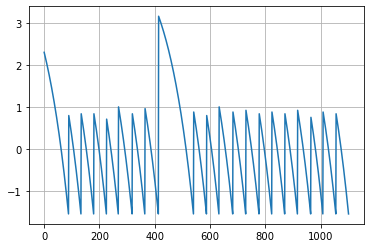

In [27]:
plt.plot(process_rewards(rewards_list),'-',)
ax=plt.gca()
ax.grid(True)

# Example of Simulation and Training

# Training the Network

In [36]:
# we define a helper function to create a batch of simulations
# and after the batch simulations, preprocess data and fit the network
def generate_episode_batches_and_train_network(n_batches=10):
    env = gym.make('Pong-v0')
    batch_state_list=[]
    batch_up_or_down_action_list=[]
    batch_rewards_list=[]
    batch_network_output_list=[]
    for i in range(n_batches):
        states_list,up_or_down_action_list,rewards_list,network_output_list = generate_episode(policy_network_model)   
        batch_state_list.extend(states_list[15:])
        batch_network_output_list.extend(network_output_list[15:])
        batch_up_or_down_action_list.extend(up_or_down_action_list[15:])
        batch_rewards_list.extend(rewards_list[15:])
    
    episode_reward=np.expand_dims(process_rewards(batch_rewards_list),1)
    x=np.array(batch_state_list)
    y_tmp = np.array(batch_up_or_down_action_list)
    y_true = np.expand_dims(y_tmp,1)
    policy_network_train.fit(x=[x,episode_reward],y=y_true)

    return batch_state_list,batch_up_or_down_action_list,batch_rewards_list,batch_network_output_list

In [37]:
train_n_times = 21 # for actual training, about 5000 may be a good start. 
for i in range(train_n_times):
    states_list,up_or_down_action_list,rewards_list,network_output_list=generate_episode_batches_and_train_network(10)
    if i%10==0:
        print("i="+str(i))
        rr=np.array(rewards_list)
        # i keep how many times we won in batch. you can use log more details more frequently
        print('count win='+str(len(rr[rr>0]))) 
        policy_network_model.save("policy_network_model_simple.h5")
        policy_network_model.save("policy_network_model_simple"+str(i)+".h5")
        with open('rews_model_simple.txt','a') as f_rew:
            f_rew.write("i="+str(i)+'       reward= '+str(len(rr[rr > 0])))
            f_rew.write("\n")

TypeError: in user code:

    C:\Users\nasbo\.conda\envs\ELTE-RL\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    <ipython-input-14-05e4278b786d>:13 loss  *
        tmp_loss = keras.layers.Lambda(lambda x:-y_true*keras.backend.log(x)-(1-y_true)*(keras.backend.log(1-x)))(tmp_pred)
    C:\Users\nasbo\.conda\envs\ELTE-RL\lib\site-packages\tensorflow\python\ops\math_ops.py:1141 binary_op_wrapper
        raise e
    C:\Users\nasbo\.conda\envs\ELTE-RL\lib\site-packages\tensorflow\python\ops\math_ops.py:1125 binary_op_wrapper
        return func(x, y, name=name)
    C:\Users\nasbo\.conda\envs\ELTE-RL\lib\site-packages\tensorflow\python\ops\math_ops.py:1457 _mul_dispatch
        return multiply(x, y, name=name)
    C:\Users\nasbo\.conda\envs\ELTE-RL\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\nasbo\.conda\envs\ELTE-RL\lib\site-packages\tensorflow\python\ops\math_ops.py:509 multiply
        return gen_math_ops.mul(x, y, name)
    C:\Users\nasbo\.conda\envs\ELTE-RL\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:6174 mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\nasbo\.conda\envs\ELTE-RL\lib\site-packages\tensorflow\python\framework\op_def_library.py:503 _apply_op_helper
        raise TypeError(

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int32 of argument 'x'.


# Playing the trained Network

In [ ]:
import time
def play_and_show_episode(policy_network):
    env = gym.make('Pong-v0')
    done=False
    observation = env.reset()
    new_observation = observation
    while done==False:
        time.sleep(1/80)
        
        processed_network_input = preprocess_frames(new_frame=new_observation,last_frame=observation)
        reshaped_input = np.expand_dims(processed_network_input,axis=0) # x shape is (80,80) so we need similar reshape(x,(1,80,80))

        up_probability = policy_network.predict(reshaped_input,batch_size=1)[0][0]
        actual_action = np.random.choice(a=[2,3],size=1,p=[up_probability,1-up_probability])
        
        env.render()
        
        observation= new_observation
        new_observation, reward, done, info = env.step(actual_action)
        if reward!=0:
            print(reward)
        if done:
            break
        
    env.close()

In [ ]:
play_and_show_episode(policy_network_model)